In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

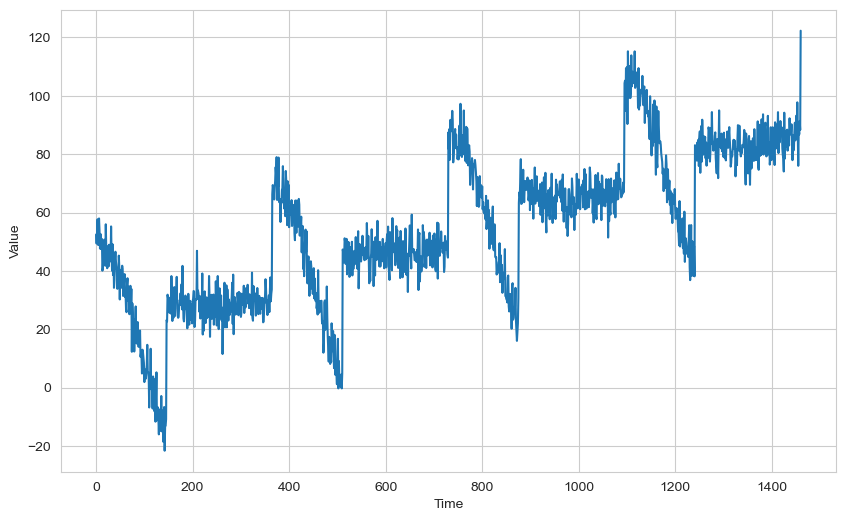

In [4]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

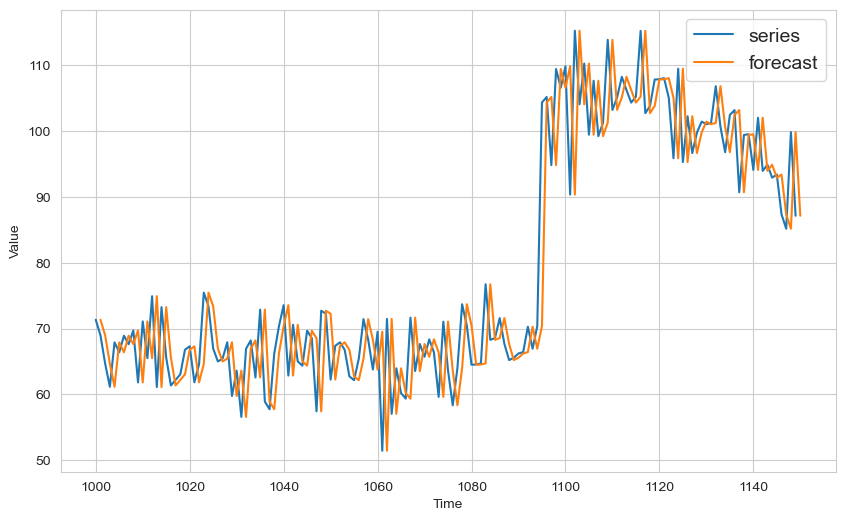

In [5]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

naive_forcast = series[split_time-1:-1]



# zoom 0-150 days
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid,start=0,end=150,label="series")
plot_series(time_valid,naive_forcast,start=1,end=151,label="forecast")
            

In [6]:
import keras
keras.metrics.mean_absolute_error(X_valid,naive_forcast).numpy()

2023-09-16 23:13:38.415002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 23:13:43.372383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5.9379085153216735

In [7]:
# Moving Average
def moving_average_forcat(series,window_size):
    forcast = []
    for time in range(len(series)-window_size):
        forcast.append(series[time:time+window_size].mean())
    return np.array(forcast)

In [8]:
def moving_average_forcast(series,window_size):
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:]-mov[:-window_size]
    return mov[window_size-1:-1]/window_size

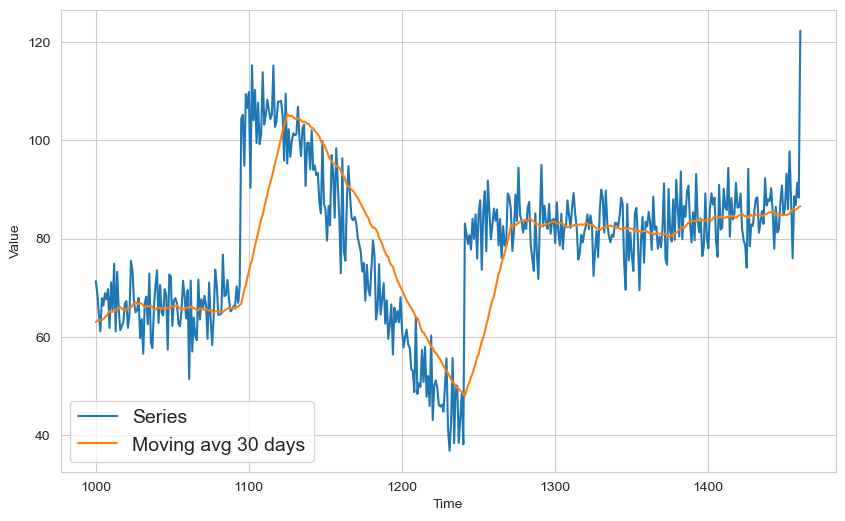

In [9]:
moving_avg = moving_average_forcast(series,30)[split_time-30:]
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid,label="Series")
plot_series(time_valid,moving_avg,label="Moving avg 30 days")

In [10]:
keras.metrics.mean_absolute_error(X_valid,moving_avg).numpy()

7.1424185706207854

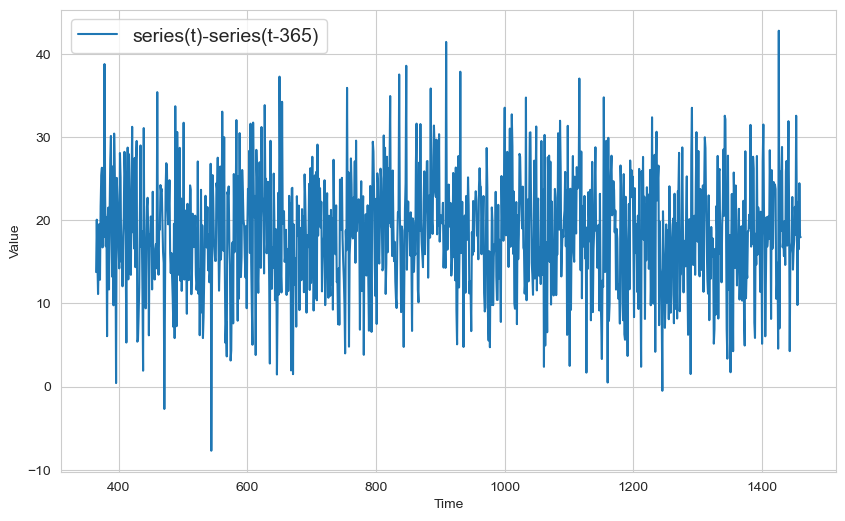

In [11]:
diff_series = (series[365:]-series[:-365])
diff_time = time[365:]
plt.figure(figsize=(10,6))
plot_series(diff_time,diff_series,label="series(t)-series(t-365)")

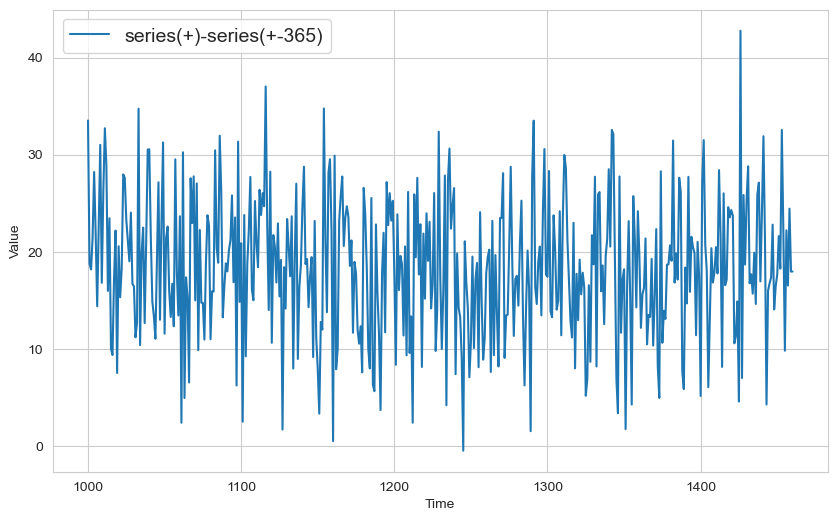

In [12]:
plt.figure(figsize=(10,6))
plot_series(time_valid,diff_series[split_time-365:],label="series(+)-series(+-365)")

In [13]:
diff_moving_avg = moving_average_forcast(diff_series,50)[split_time-365-50:]

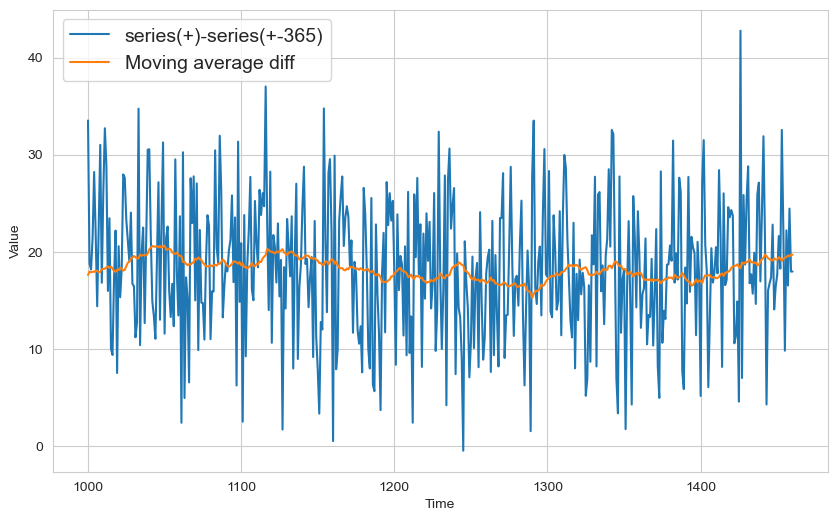

In [14]:
plt.figure(figsize=(10,6))
plot_series(time_valid,diff_series[split_time-365:],label="series(+)-series(+-365)")
plot_series(time_valid,diff_moving_avg,label="Moving average diff")

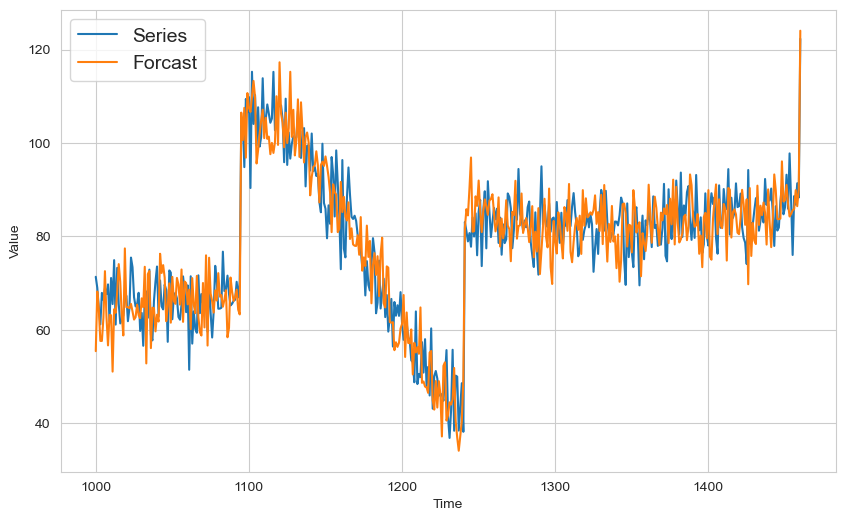

In [15]:
diff_moving_avg_plus_past = series[split_time-365:-365]+diff_moving_avg

plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid,label="Series")
plot_series(time_valid,diff_moving_avg_plus_past,label="Forcast")

In [16]:
keras.metrics.mean_absolute_error(X_valid,diff_moving_avg_plus_past).numpy()

5.8393105629958955

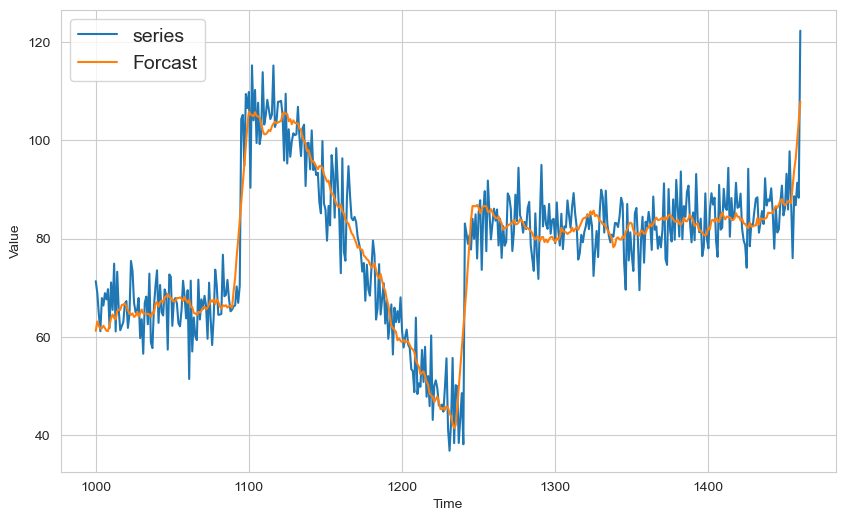

In [17]:
diff_moving_avg_plus_smooth_past = moving_average_forcast(series[split_time-370:-359],11)+diff_moving_avg


plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid,label="series")
plot_series(time_valid,diff_moving_avg_plus_smooth_past,label="Forcast")

In [18]:
keras.metrics.mean_absolute_error(X_valid,diff_moving_avg_plus_smooth_past).numpy()

4.566859958970772